### Imports


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier


### Load Data

In [2]:
data = pd.read_csv("data/mushrooms.csv")


### Data Exploration

In [3]:
data.head(10)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,e,e,s,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,s,m


Display the distribution of edible and poisonous mushrooms.

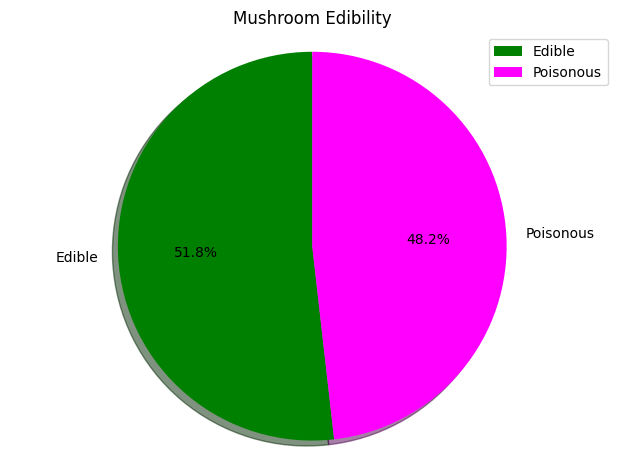

In [4]:
labels = "Edible", "Poisonous"
sizes = [
    data.describe()["class"]["freq"],
    data.describe()["class"]["count"] - data.describe()["class"]["freq"],
]

fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
    colors=["green", "magenta"],
)

ax.set_title("Mushroom Edibility")
ax.legend(labels, loc="upper right")
ax.axis("equal")
plt.tight_layout()

plt.show()


Mushroom edibility by cap shape

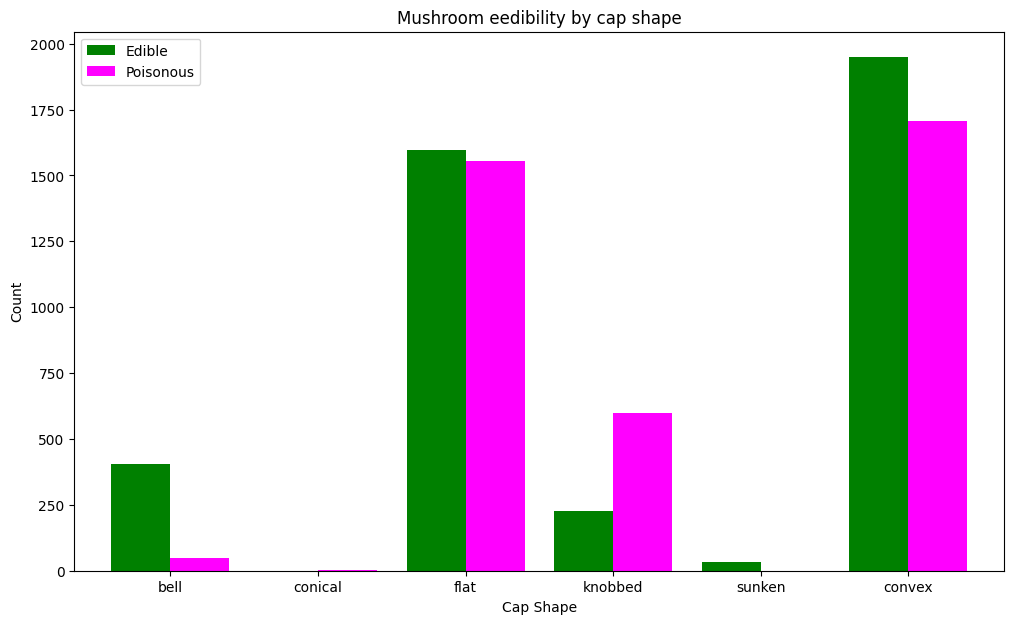

In [5]:
cap_shapes = data.groupby(["cap-shape", "class"]).size().unstack()
cap_shapes.fillna(0)
cap_shapes_mapping = {
    "b": "bell",
    "c": "conical",
    "x": "convex",
    "f": "flat",
    "k": "knobbed",
    "s": "sunken",
}

cap_shapes.rename(index=cap_shapes_mapping, inplace=True)

ax = cap_shapes.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Mushroom eedibility by cap shape")
ax.set_ylabel("Count")
ax.set_xlabel("Cap Shape")
labels = ["Edible", "Poisonous"]

ax.legend(labels, loc="upper left")
plt.show()


Mushroom edibility by cap surface

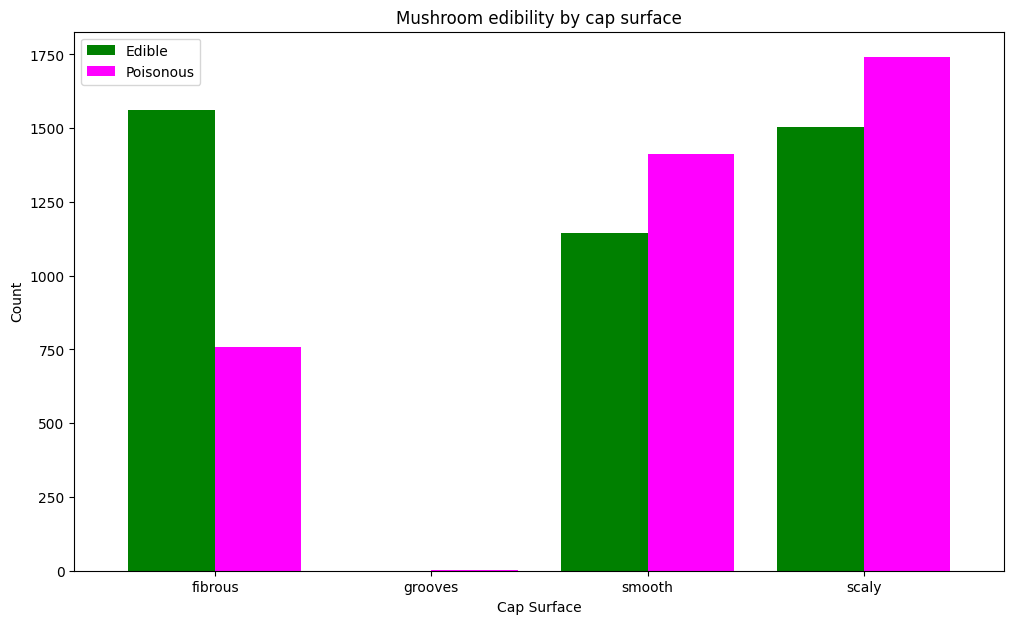

In [6]:
cap_surfaces = data.groupby(["cap-surface", "class"]).size().unstack()
cap_surfaces.fillna(0)

cap_surfaces_mapping = {
    "f": "fibrous",
    "g": "grooves",
    "s": "smooth",
    "y": "scaly",
}

cap_surfaces.rename(index=cap_surfaces_mapping, inplace=True)

ax = cap_surfaces.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Mushroom edibility by cap surface")
ax.set_ylabel("Count")
ax.set_xlabel("Cap Surface")
labels = ["Edible", "Poisonous"]

ax.legend(labels, loc="upper left")
plt.show()


Mushroom edibility by color

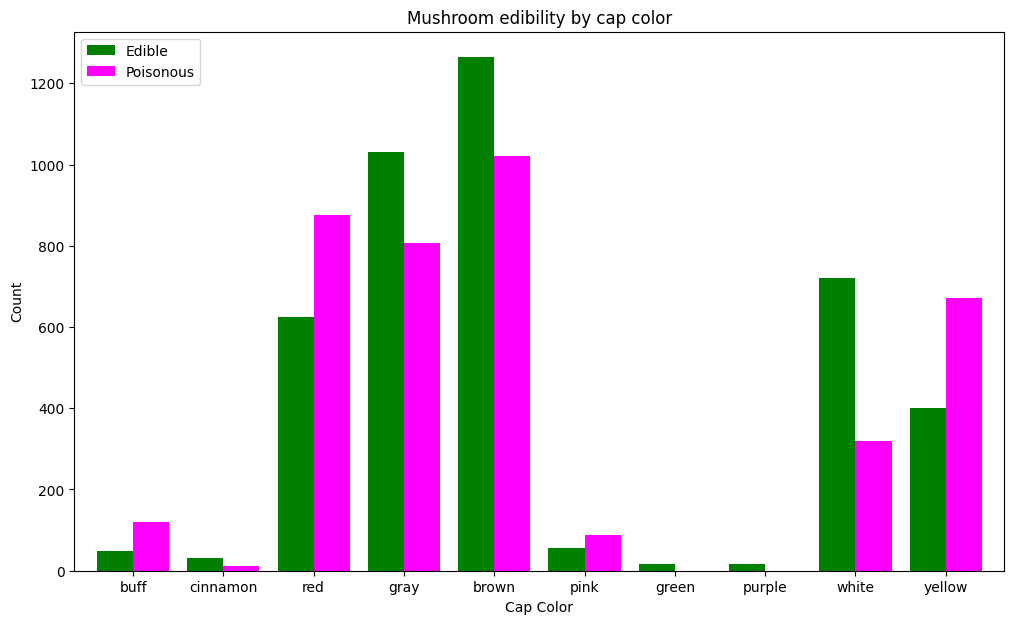

In [7]:
cap_colors = data.groupby(["cap-color", "class"]).size().unstack()
cap_colors.fillna(0)

cap_colors_mapping = {
    "n": "brown",
    "b": "buff",
    "c": "cinnamon",
    "g": "gray",
    "r": "green",
    "p": "pink",
    "u": "purple",
    "e": "red",
    "w": "white",
    "y": "yellow",
}

cap_colors.rename(index=cap_colors_mapping, inplace=True)

ax = cap_colors.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Mushroom edibility by cap color")
ax.set_xlabel("Cap Color")
ax.set_ylabel("Count")

labels = ["Edible", "Poisonous"]
ax.legend(labels, loc="upper left")
plt.show()


Mushroom edibility by bruises

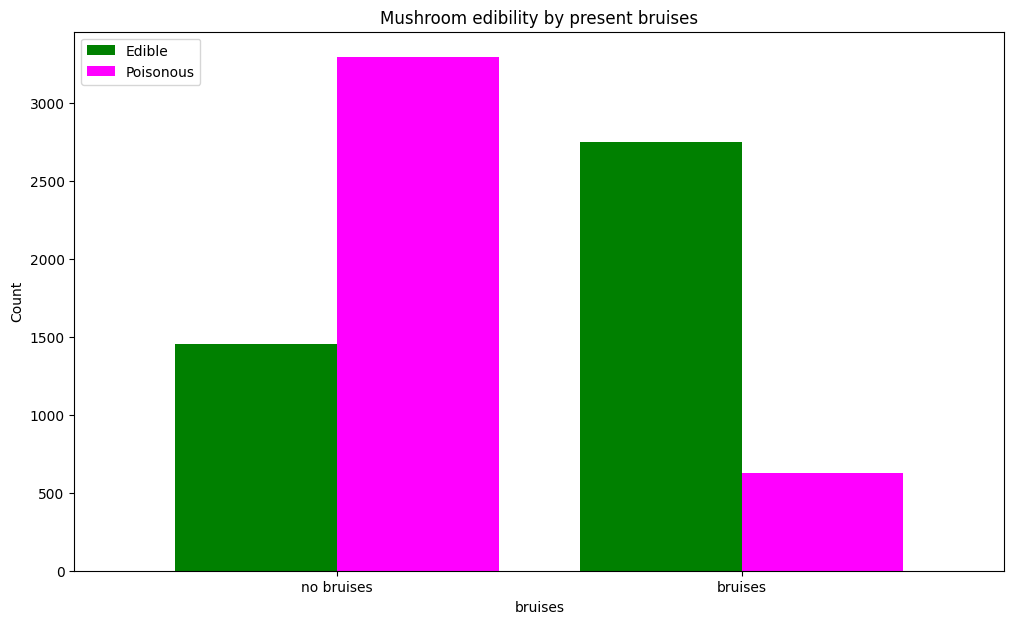

In [8]:
bruises = data.groupby(["bruises", "class"]).size().unstack()

bruise_mapping = {"f": "no bruises", "t": "bruises"}

bruises.rename(index=bruise_mapping, inplace=True)

ax = bruises.plot.bar(color=["green", "magenta"], rot=0, figsize=(12, 7), width=0.8)

ax.set_title("Mushroom edibility by present bruises")
ax.set_ylabel("Count")

labels = ["Edible", "Poisonous"]
plt.legend(labels, loc="upper left")
plt.show()


### Declare utility functions to imitiate missing data

In [9]:
def create_missing_data(data, missing_ratio):
    """
    Create random missing data in a pandas DataFrame.

    Parameters:
        data (pandas.DataFrame): The input DataFrame.
        missing_ratio (float): The ratio of missing values to create (between 0 and 1).

    Returns:
        pandas.DataFrame: The DataFrame with random missing values.
    """

    data_with_missing = data.copy()
    num_missing_values = int(data.size * missing_ratio)
    missing_indices = np.random.choice(data.size, size=num_missing_values, replace=False)
    data_with_missing.values.flat[missing_indices] = np.nan

    return data_with_missing


In [10]:
def fill_with_most_common(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col


### Train Models

Split the data into train and test 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("class", axis=1),
    data["class"],
    test_size=0.2,
    shuffle=True,
    random_state=42,
    stratify=data["class"],
)


## Create missing data

In [ ]:
X_train = create_missing_data(X_train, 0.7)
X_train = X_train.apply(lambda col: fill_with_most_common(col))

X_test = create_missing_data(X_test, 0.7)
X_test = X_test.apply(lambda col: fill_with_most_common(col))


Replace edible with 1 and poisonous with 0

In [12]:
y_train = y_train.map({"e": 0, "p": 1})
y_test = y_test.map({"e": 0, "p": 1})


### Preprocessing

Create preprocessor

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            StandardScaler(),
            data.drop("class", axis=1).select_dtypes(exclude="object").columns,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            data.drop("class", axis=1).select_dtypes(include="object").columns,
        ),
    ]
)


### Create XGBoost model

In [14]:
xgb_model = XGBClassifier()

xgb_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", xgb_model)])


Search for the parameters with Grid Search

In [15]:
param_grid = {
    "classifier__n_estimators": [50, 100, 150],
    "classifier__learning_rate": [0.1, 0.01, 0.001],
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)


In [16]:
grid_search.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(grid_search.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


Best parameters set found on development set:
{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 150}


Predict scores

In [17]:
y_pred = grid_search.predict(X_test)

print("Accuracy score: ", accuracy_score(y_test, y_pred))


Accuracy score:  0.8867692307692308


### Create Neural Network model

In [18]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, CategoryEncoding

from sklearn.preprocessing import OneHotEncoder


Encode input data with OneHotEncoder

In [19]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_train_onehot = onehot_encoder.fit_transform(X_train)
X_test_onehot = onehot_encoder.transform(X_test)

print(X_train_onehot.shape[1])
print(X_test_onehot.shape[1])


117
117


Create the layers for the neural network

In [20]:
neural_network = Sequential()

neural_network.add(Dense(units=16, activation="elu", input_shape=(X_train_onehot.shape[1],)))
neural_network.add(Dense(units=16, activation="elu"))
neural_network.add(Dense(units=1, activation="sigmoid"))

neural_network.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


2023-06-11 17:07:15.546536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 17:07:15.731175: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
nn_history = neural_network.fit(X_train_onehot, y_train, epochs=100, batch_size=32)


Epoch 1/100
204/204 [==============================] - 2s 4ms/step - loss: 0.4524 - accuracy: 0.8141
Epoch 2/100
204/204 [==============================] - 1s 3ms/step - loss: 0.3090 - accuracy: 0.8684
Epoch 3/100
204/204 [==============================] - 1s 3ms/step - loss: 0.2904 - accuracy: 0.8724
Epoch 4/100
204/204 [==============================] - 1s 3ms/step - loss: 0.2804 - accuracy: 0.8772
Epoch 5/100
204/204 [==============================] - 1s 3ms/step - loss: 0.2800 - accuracy: 0.8744
Epoch 6/100
204/204 [==============================] - 1s 4ms/step - loss: 0.2753 - accuracy: 0.8771
Epoch 7/100
204/204 [==============================] - 1s 3ms/step - loss: 0.2718 - accuracy: 0.8812
Epoch 8/100
204/204 [==============================] - 1s 3ms/step - loss: 0.2706 - accuracy: 0.8792
Epoch 9/100
204/204 [==============================] - 1s 4ms/step - loss: 0.2700 - accuracy: 0.8780
Epoch 10/100
204/204 [==============================] - 1s 4ms/step - loss: 0.2650 - accura

Evaluate neural network

In [22]:
neural_network.evaluate(X_test_onehot, y_test)


51/51 [==============================] - 0s 3ms/step - loss: 0.2345 - accuracy: 0.8954


[0.23449936509132385, 0.8953846096992493]

Graph the loss and accuracy

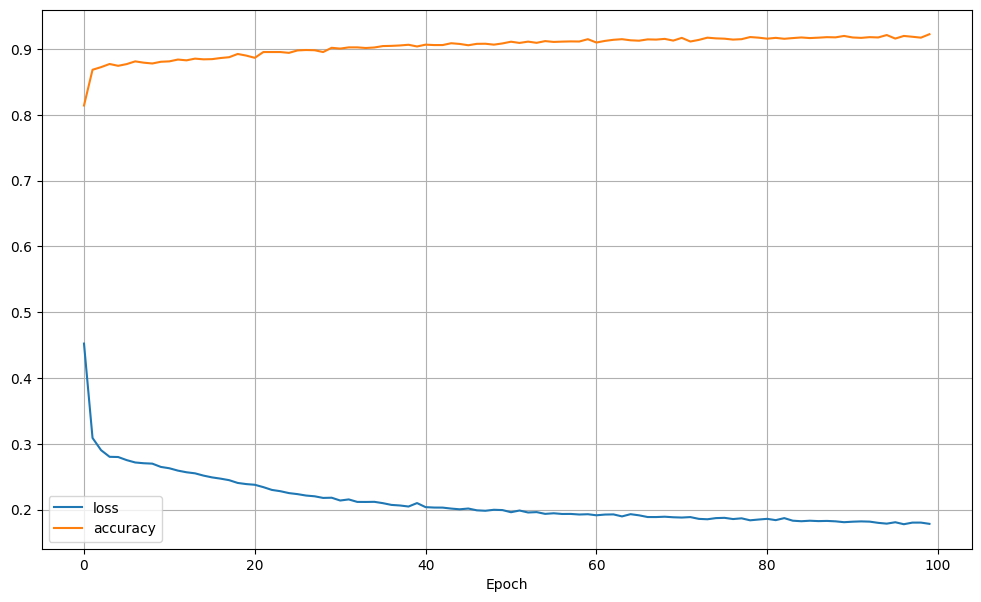

In [23]:
pd.DataFrame(nn_history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.xlabel("Epoch")
plt.show()


## Convolutional Neural Network

In [24]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    CategoryEncoding,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
    Input,
)

from sklearn.preprocessing import OneHotEncoder


Encode the data with OneHotEncoder

In [25]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_train_onehot = onehot_encoder.fit_transform(X_train)
X_test_onehot = onehot_encoder.transform(X_test)

print(X_train_onehot.shape[1])
print(X_test_onehot.shape[1])


117
117


Create the layers for CNN

In [26]:
cnn = Sequential()

# create convolutional neural network

cnn.add(
    Conv1D(
        filters=16,
        kernel_size=3,
        strides=1,
        padding="same",
        input_shape=(X_train_onehot.shape[1], 1),
    )
)
cnn.add(BatchNormalization())
cnn.add(Activation("relu"))
cnn.add(MaxPooling1D(pool_size=2, strides=2))

cnn.add(
    Conv1D(
        filters=32,
        kernel_size=3,
        strides=1,
        padding="same",
    )
)

cnn.add(BatchNormalization())
cnn.add(Activation("relu"))
cnn.add(MaxPooling1D(pool_size=2, strides=2))
cnn.add(Flatten())

cnn.add(Dense(units=16, activation="elu"))
cnn.add(Dense(units=16, activation="elu"))
cnn.add(Dense(units=1, activation="sigmoid"))

cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [27]:
cnn_history = cnn.fit(
    X_train_onehot.reshape(X_train_onehot.shape[0], X_train_onehot.shape[1], 1),
    y_train,
    epochs=100,
    batch_size=32,
)


Epoch 1/100
204/204 [==============================] - 4s 10ms/step - loss: 0.4200 - accuracy: 0.8000
Epoch 2/100
204/204 [==============================] - 2s 11ms/step - loss: 0.3265 - accuracy: 0.8554
Epoch 3/100
204/204 [==============================] - 2s 11ms/step - loss: 0.3066 - accuracy: 0.8587
Epoch 4/100
204/204 [==============================] - 2s 11ms/step - loss: 0.2903 - accuracy: 0.8675
Epoch 5/100
204/204 [==============================] - 2s 10ms/step - loss: 0.2919 - accuracy: 0.8680
Epoch 6/100
204/204 [==============================] - 2s 11ms/step - loss: 0.2661 - accuracy: 0.8801
Epoch 7/100
204/204 [==============================] - 2s 10ms/step - loss: 0.2676 - accuracy: 0.8746
Epoch 8/100
204/204 [==============================] - 2s 11ms/step - loss: 0.2624 - accuracy: 0.8784
Epoch 9/100
204/204 [==============================] - 2s 11ms/step - loss: 0.2520 - accuracy: 0.8871
Epoch 10/100
204/204 [==============================] - 2s 11ms/step - loss: 0.239

Evaluate CNN

In [28]:
cnn.evaluate(X_test_onehot.reshape(X_test_onehot.shape[0], X_test_onehot.shape[1], 1), y_test)


51/51 [==============================] - 1s 5ms/step - loss: 0.3629 - accuracy: 0.8855


[0.3628914952278137, 0.8855384588241577]

Plot the loss and accuracy for CNN

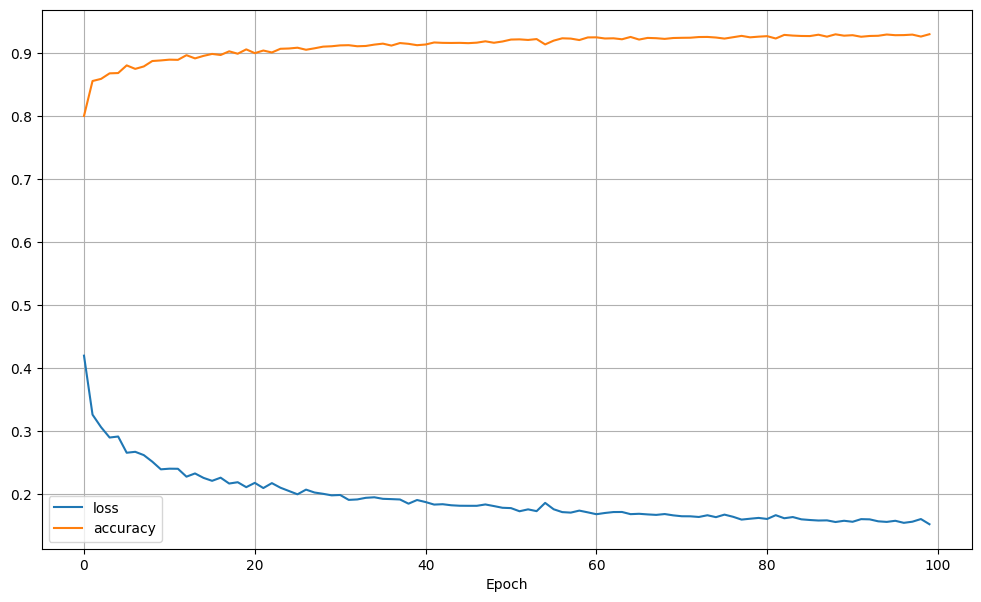

In [29]:
pd.DataFrame(cnn_history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.xlabel("Epoch")
plt.show()
